In [3]:
import torch
import pandas as pd
# 进行csv的生成
import random
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import re
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
# from transformers import Trainer
from transformers import TrainingArguments
from torch.nn.utils.rnn import pad_sequence
torch.cuda.set_device(0)

#从本地文件提取文件路径(要用/)，标签，保存至info_array数组中，到处为motion.csv文件
dataset_dir='./train'
dataset_posdir='./train/pos'
dataset_negdir='./train/neg'
classes=os.listdir(dataset_posdir)

info_array=[]
col=['index','score','label','filepath']
# 设置需要的数据
for filename in os.listdir(dataset_posdir):
    filepath=dataset_posdir+'/'+filename
    filename_without_extension = os.path.splitext(os.path.basename(filepath))[0]
    split_name=filename_without_extension.split('_')
    index=split_name[0]
    score=split_name[1]
    # label='pos'
    label=1
    info_array.append([index,score,label,filepath])
for filename in os.listdir(dataset_negdir):
    filepath=dataset_negdir+'/'+filename
    filename_without_extension = os.path.splitext(os.path.basename(filepath))[0]
    split_name=filename_without_extension.split('_')
    index=split_name[0]
    score=split_name[1]
    # label='neg'
    label=0
    info_array.append([index,score,label,filepath])
    
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

numpy_info_array = np.array(info_array)  
df=pd.DataFrame(numpy_info_array,columns=col)
df.to_csv('./motion.csv',encoding='utf-8')

# 重写dataset数据集部分，定义数据格式
class motionDataset(Dataset):
    def __init__(self,dataset_dir,csv_path):
        self.csv_path=csv_path
        self.df=pd.read_csv(self.csv_path,encoding='utf-8')
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        # 获取目标文本
        # memo_content储存一个文件中的文本，保存数据类型是字符串，做了去除除单词符号外元素的处理
        if idx >= len(self.df):
            raise IndexError("Index out of range.")
        memo_filepath=self.df['filepath'][idx]
        with open(memo_filepath,'r',encoding='utf-8')as f:
            memo_content=f.read()
        memo_content=re.sub(r'[^\w\s]', '', memo_content)  
        
        encoding = tokenizer.encode_plus(
            memo_content,
            add_special_tokens=True,
            max_length=500,
            return_tensors='pt',
            padding='max_length',
            truncation=True
        )
        
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        token_type_ids = encoding['token_type_ids']

        # 将类别保存为y_train，数据类型为字符串
        y_train = self.df['label'][idx]
        
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids, 'label': y_train}
train_ds=motionDataset('./train','./motion.csv')
len(train_ds)

25000

In [4]:
# 对训练集做分割处理，便于后续训练测试   random_split
from torch.utils.data import random_split
num_sample=len(train_ds)
train_percent=0.8
train_num=int(train_percent*num_sample)
test_num=num_sample-train_num
train_ds1,train_ds2=random_split(train_ds,[train_num,test_num])
print(len(train_ds1),len(train_ds2))

# 批处理函数，由于各个文本长不同，分别使用0进行填充，同时label转换成tensor类型数据
def collate_fn(data):
    # 按input_ids长度进行降序排序，提高填充效率
    data.sort(key=lambda x: len(x['input_ids']), reverse=True)

    max_length = 500  # 设置一个最大长度，根据模型的最大长度进行调整，同时把数据处理成模型需要数据的形状

    input_ids = [item['input_ids'][:, :max_length] for item in data]  # 截断或填充到相同的长度
    attention_mask = [item['attention_mask'][:, :max_length] for item in data]
    token_type_ids = [item['token_type_ids'][:, :max_length] for item in data] 
    labels = [item['label'] for item in data]

    # Pad sequences after sorting   batch_first表示张量输出维度是第一个维度   padding_value表示用0填充     squeeze表示去除不需要的维度
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0).squeeze(1)
    padded_attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0).squeeze(1)
    padded_token_type_ids = pad_sequence(token_type_ids, batch_first=True, padding_value=0).squeeze(1)

    # Convert labels to one-dimensional tensor，后续模型需要long类型的数据，将label转化为long的tensor
    labels = torch.tensor(labels, dtype=torch.long)

    # return {'input_ids': padded_input_ids, 'attention_mask': padded_attention_mask,
    #         'token_type_ids': padded_token_type_ids, 'label': labels}   要直接返回新数据名称
    return padded_input_ids, padded_attention_mask, padded_token_type_ids, labels      
    
# 重写dataloader，定义批次大小，collate_fn函数，打乱
train1_dataloader=DataLoader(train_ds1,batch_size=16,shuffle=True,collate_fn=collate_fn)
train2_dataloader=DataLoader(train_ds2,batch_size=16,shuffle=True,collate_fn=collate_fn)

# def collate_fn(data):

20000 5000


In [5]:
# 加载字典和分词工具
from transformers import BertModel

#加载预训练模型，迁移学习，使用一个在大规模文本数据上预训练的模型
pretrained = BertModel.from_pretrained('bert-base-uncased').to("cuda:0")

In [6]:
#定义下游任务模型
class Model(torch.nn.Module):
    def __init__(self,pretrained):
        # 这里要把pretrained嵌入
        super().__init__()
        self.fc = torch.nn.Linear(768, 2)
        # fc:输出层，第一个参数为全连接层的输入，第二个参数时表明输出为两个分类，该函数让模型

    def forward(self, input_ids, attention_mask, token_type_ids):
        with torch.no_grad():
            out = pretrained(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)
            # 用训练模型做计算，将抽取的特征放到全连接神经网络中

        out = self.fc(out.last_hidden_state[:, 0])
        # 取零和bert设计有关

        out = out.softmax(dim=1)

        return out


model = Model(pretrained)
if torch.cuda.is_available():
    model = model.to("cuda:0")
for param in pretrained.parameters():
    param.requires_grad_(False)
# 遍历所有model中的所有参数

In [7]:
from transformers import AdamW
torch.cuda.set_device("cuda:0")
#训练
optimizer = AdamW(model.parameters(), lr=0.0003)
# 交叉熵计算损失，做梯度下降处理
criterion = torch.nn.CrossEntropyLoss().to("cuda:0")
model.train()
num_epochs = 1

for epoch in range(num_epochs):
    print(epoch+1)
    correct=0
    totalLoss=0
    total=0
    for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(train1_dataloader):
        input_ids=input_ids.to("cuda:0")   
        attention_mask=attention_mask.to("cuda:0")   
        token_type_ids=token_type_ids.to("cuda:0")   
        labels=labels.to("cuda:0")
        out = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids)   
        optimizer.zero_grad()
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        out = out.argmax(dim=1) 
        total+=len(labels)
        correct+=(out == labels).sum().item()
        totalLoss+=loss.item()
        # if i % 10 == 0:
        #     out = out.argmax(dim=1) 
        #     # 获取out输出张量中沿第一个维度找到每行中的最大值的索引
        #     accuracy = (out == labels).sum().item() / len(labels)

        # if i == 1200:
        #     print(loss.item(), accuracy)
    print(correct/total,totalLoss/total)

D:\miniconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


1
0.78075 0.035166783376038076


In [8]:
dataset_dir1='./test'
dataset_posdir1='./train/pos'
dataset_negdir1='./train/neg'
classes=os.listdir(dataset_posdir1)

info_array1=[]
col1=['index','score','label','filepath']

for filename in os.listdir(dataset_posdir1):
    filepath=dataset_posdir1+'/'+filename
    filename_without_extension = os.path.splitext(os.path.basename(filepath))[0]
    split_name=filename_without_extension.split('_')
    index=split_name[0]
    score=split_name[1]
    # label='pos'
    label=1
    info_array1.append([index,score,label,filepath])
for filename in os.listdir(dataset_negdir1):
    filepath=dataset_negdir1+'/'+filename
    filename_without_extension = os.path.splitext(os.path.basename(filepath))[0]
    split_name=filename_without_extension.split('_')
    index=split_name[0]
    score=split_name[1]
    # label='neg'
    label=0
    info_array1.append([index,score,label,filepath])

numpy_info_array1 = np.array(info_array1)  
df=pd.DataFrame(numpy_info_array1,columns=col1)
df.to_csv('./emotion_test.csv',encoding='utf-8')

test_ds=motionDataset('./test','./emotion_test.csv')

len(test_ds)

25000

In [9]:
test_dataloader=DataLoader(test_ds,batch_size=16,shuffle=True,collate_fn=collate_fn)
import numpy as np
pred_array = np.array([])
cor_array = np.array([])
out_list=[]

def test():
    model.eval()
    correct = 0
    total = 0
    global cor_array  # 将cor_array声明为全局变量
    global pred_array  # 将pred_array声明为全局变量
    for i, (input_ids, attention_mask, token_type_ids,
            labels) in enumerate(test_dataloader):
        
        with torch.no_grad():
            input_ids=input_ids.to("cuda:0")   
            attention_mask=attention_mask.to("cuda:0")   
            token_type_ids=token_type_ids.to("cuda:0")   
            labels=labels.to("cuda:0")
            out = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)

        out_list.append(out)
        out = out.argmax(dim=1)
        correct += (out == labels).sum().item()
        total += len(labels)
        cor_array = np.append(cor_array, labels.cpu().numpy())
        pred_array = np.append(pred_array, out.cpu().numpy())

    print(correct,total,correct / total)
test()

20424 25000 0.81696


In [15]:
score = np.concatenate([tensor.cpu().numpy() for tensor in out_list], axis=0)
print(score)

[[0.24311863 0.7568814 ]
 [0.14360818 0.85639185]
 [0.01187765 0.9881223 ]
 ...
 [0.6415671  0.35843286]
 [0.28577268 0.71422726]
 [0.9663688  0.03363118]]


In [16]:
from sklearn.metrics import * 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import binarize
import pandas as pd

accuracy = accuracy_score(cor_array, pred_array)
precision = precision_score(cor_array, pred_array, labels=None)
recall = recall_score(cor_array, pred_array, average='macro')
print("精度: ",accuracy,"  查准率P: ",precision,"  召回率: ",recall) 

精度:  0.81696   查准率P:  0.8266820580474934   召回率:  0.81696


In [42]:
fpr = dict()
tpr = dict()
roc_auc = dict()
# 计算fpr，tpr，用正样本概率作为阈值
fpr, tpr, _ = roc_curve(cor_array, score[:, 1])
roc_auc = auc(fpr, tpr)

In [43]:
print(fpr)

[0.      0.      0.      ... 0.98688 0.98688 1.     ]


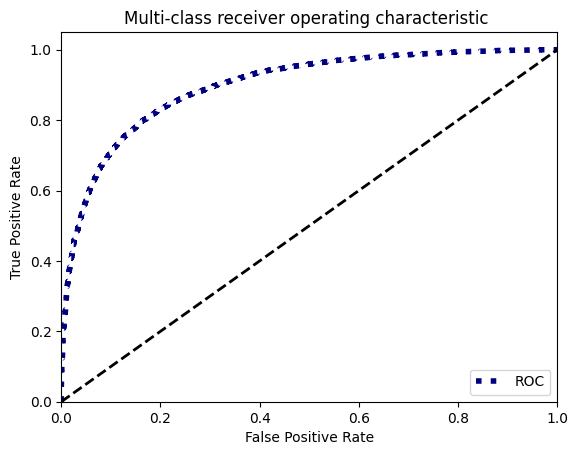

In [44]:
# line width设置曲线宽度
lw = 2

# 创建一个新的图像
plt.figure()

# 绘制宏平均 ROC 曲线以及每个类别的 ROC 曲线
# 宏观平均（macro-average），计算所有真阳率和假阳率的平均值得到总体性能指标
# label语句参数，用来设置图例，显示的文本信息{0:0.2f} 是一个格式化字符串，用于将 roc_auc["macro"] 的值插入到字符串中，并保留两位小数
# 参数：fpr，tpr
plt.plot(fpr, tpr,color='navy', linestyle=':', linewidth=4, label='ROC')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)

# 设置xy轴的范围
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# 设置xy轴的标签
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# 设置标题
plt.title('Multi-class receiver operating characteristic ')

# 增加图例
plt.legend(loc="lower right")
plt.show()

In [45]:
print(f"该模型的auc大小为:{roc_auc:2f}")

该模型的auc大小为:0.896944
